In [1]:
import os
import yaml
import glob

import numpy as np
import pandas as pd

import math
from natsort import natsorted

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import ListedColormap

from PIL import Image, ImageDraw

from tifffile import imread
from tifffile import imsave

import hdbscan
from umap import UMAP

from joblib import Memory

import tifffile

import zarr
import napari
import dask.array as da

from skimage.util import img_as_float
from skimage.color import gray2rgb

In [2]:
# TOPACIO sample number
sample = '840063_0110'

In [3]:
def single_channel_pyramid(tiff_path, channel):

    target_filepath = tiff_path
    tiff = tifffile.TiffFile(target_filepath, is_ome=False)

    pyramid = [
        zarr.open(s[channel].aszarr())
        for s in tiff.series[0].levels
        ]

    pyramid = [
        da.from_zarr(z)
        for z in pyramid
        ]

    return pyramid

In [4]:
def categorical_cmap(numUniqueSamples, numCatagories, cmap='tab10', continuous=False):

    numSubcatagories = math.ceil(numUniqueSamples/numCatagories)

    if numCatagories > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0, 1, numCatagories))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(numCatagories, dtype=int))
        # rearrange hue order to taste
        cd = {
            'B': 0, 'O': 1, 'G': 2, 'R': 3, 'Pu': 4,
            'Br': 5, 'Pi': 6, 'Gr': 7, 'Y': 8, 'Cy': 9,
            }
        myorder = [
            cd['B'], cd['O'], cd['G'], cd['Pu'], cd['Y'],
            cd['R'], cd['Cy'], cd['Br'], cd['Gr'], cd['Pi']
            ]
        ccolors = [ccolors[i] for i in myorder]

        # use Okabe and Ito color-safe palette for first 6 colors
        # ccolors[0] = np.array([0.91, 0.29, 0.235]) #E84A3C
        # ccolors[1] = np.array([0.18, 0.16, 0.15]) #2E2926
        ccolors[0] = np.array([0.0, 0.447, 0.698, 1.0])  # blue
        ccolors[1] = np.array([0.902, 0.624, 0.0, 1.0])  # orange
        ccolors[2] = np.array([0.0, 0.620, 0.451, 1.0])  # bluish green
        ccolors[3] = np.array([0.8, 0.475, 0.655, 1.0])  # reddish purple
        ccolors[4] = np.array([0.941, 0.894, 0.259, 1.0])  # yellow
        ccolors[5] = np.array([0.835, 0.369, 0.0, 1.0])  # vermillion

    cols = np.zeros((numCatagories * numSubcatagories, 3))
    for i, c in enumerate(ccolors):
        chsv = colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv, numSubcatagories).reshape(numSubcatagories, 3)
        arhsv[:, 1] = np.linspace(chsv[1], 0.25, numSubcatagories)
        arhsv[:, 2] = np.linspace(chsv[2], 1, numSubcatagories)
        rgb = colors.hsv_to_rgb(arhsv)
        cols[i * numSubcatagories:(i + 1) * numSubcatagories, :] = rgb
    cmap = colors.ListedColormap(cols)

    # trim colors if necessary
    if len(cmap.colors) > numUniqueSamples:
        trim = len(cmap.colors) - numUniqueSamples
        cmap_colors = cmap.colors[:-trim]
        cmap = colors.ListedColormap(cmap_colors, name='from_list', N=None)

    return cmap

In [5]:
# output dir
save_dir = '../output/ExtFig1a,b'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [6]:
# assign file path to TOPACIO OME-TIFF (THIS IMAGE IS NOT BACKGROUND SUBTRACTED)
img_path = f'../datasets/Dataset1(TOPACIO)/no_background_subtraction/{sample}.ome.tif'

# read raw sc data
sc_data = pd.read_csv(f'../datasets/Dataset1(TOPACIO)/no_background_subtraction/unmicst2-{sample}.csv')

sc_data.columns = [i.split('_cellRingMask')[0] for i in sc_data.columns]

# read markers.csv
markers = pd.read_csv('../datasets/Dataset1(TOPACIO)/markers.csv')

In [7]:
# isolate immunomarker channels
exclude = ['antiRat', 'antiRabbit', 'antiGoat', 'pSTAT1', 'Ki67', 'STING', 'pTBK1', 'pSTAT3', 'PCNA', 'HLAA', 'cPARP']
include = [i for i in sc_data.columns if 'DNA' not in i if i not in exclude if i in list(markers['marker_name'])]

# log-transform antibody expression data
transformed_data = np.log10(sc_data[include] + 0.00001)
sc_data.update(transformed_data)

In [8]:
# define image crop window
row_min = 10000
row_max = 14000
col_min = 17000
col_max = 20000

# select cells within cropped image
data_crop = sc_data[
    (sc_data['X_centroid'].between(col_min, col_max)) &
    (sc_data['Y_centroid'].between(row_min, row_max))
    ].copy()

# transform x, y coordinates of cells within cropped image
data_crop['X_centroid'] = data_crop['X_centroid']-col_min
data_crop['Y_centroid'] = data_crop['Y_centroid']-row_min

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


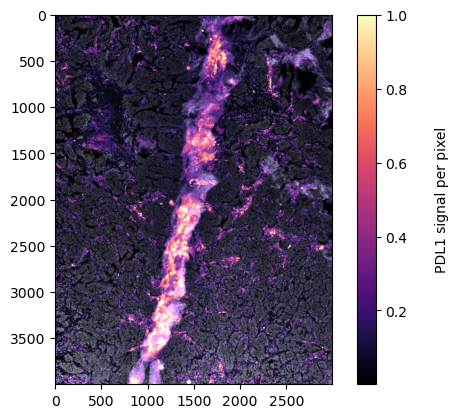

In [9]:
# read DNA1 image for matplotlib plot and crop
dna = imread(img_path, key=0)
dna_float = img_as_float(dna)
dna_float = (dna_float - np.min(dna_float)) / (np.max(dna_float) - np.min(dna_float))  # normalize 0-1
dna_crop = dna_float[row_min:row_max, col_min:col_max]
dna_crop_rgb = gray2rgb(dna_crop)
dna_crop_rgb /= 2.0  # modify DNA intensity if needed

# read PDL1 image
pdl1 = imread(img_path, key=6)
pdl1_float = img_as_float(pdl1)
pdl1_float = (pdl1_float - np.min(pdl1_float)) / (np.max(pdl1_float) - np.min(pdl1_float))  # normalize 0-1
pdl1_crop = pdl1_float[row_min:row_max, col_min:col_max]
bottom_cutoff = 0.01
top_cutoff = 0.1
pdl1_crop = np.clip(pdl1_crop, bottom_cutoff, top_cutoff)
pdl1_crop = (pdl1_crop - np.min(pdl1_crop)) / (np.max(pdl1_crop) - np.min(pdl1_crop))  # normalize 0-1
pdl1_crop_rgb = plt.cm.magma(pdl1_crop) # converts to RGBA automatically
pdl1_crop_rgb = pdl1_crop_rgb[:, :, 0:3]  # drop alpha dimension

dna_crop_rgb += pdl1_crop_rgb

plt.imshow(dna_crop_rgb, cmap='magma')
cbar = plt.colorbar()
cbar.set_alpha(1.0)
cbar.set_label('PDL1 signal per pixel', labelpad=20, rotation=90)
plt.savefig(os.path.join(save_dir, 'pdl1.png'), dpi=1000)
plt.savefig(os.path.join(save_dir, 'pdl1.pdf'))
plt.show()
plt.close('all')

In [10]:
# open TOPACIO image in Napari
viewer = napari.view_image(dna_crop, opacity=0.5, rgb=False, name='DNA1')

viewer.add_image(pdl1_crop, rgb=False, blending='additive',colormap='magma', visible=True, name='PDL1')

# view existing ROIs in Napari
if os.path.exists('../rois/ExtFig1a,b.yml'):
    
    polygon_dict = yaml.safe_load(open('../rois/ExtFig1a,b.yml'))
    
    shapes = [polygon_dict[i][0] for
              i in range(0, len(polygon_dict.keys()))]
    polygons = [polygon_dict[i][1] for
              i in range(0, len(polygon_dict.keys()))]

    selection_layer = viewer.add_shapes(
        data=polygons,
        shape_type=shapes,
        ndim=2,
        face_color=[0.0, 1.0, 0.0, 0.0],  # [1.0, 1.0, 1.0, 0.2]
        edge_color=[0.0, 1.0, 0.0, 1.0], # [0.0, 0.66, 1.0, 1.0]
        edge_width=20.0,
        name='ROI(s)')
else:
    selection_layer = viewer.add_shapes(
    shape_type='polygon', ndim=2, face_color=[1.0, 1.0, 1.0, 0.2],
    edge_color=[0.0, 0.66, 1.0, 1.0], edge_width=10.0, name='ROI(s)'
    )

napari.run()

# store ROIs
for e, (shape_type, roi) in enumerate(
        zip(selection_layer.shape_type, selection_layer.data)):
    polygon_dict[e] = [shape_type, roi.tolist()]
f = open('../rois/ExtFig1a,b.yml', 'w')
yaml.dump(polygon_dict, f)

In [11]:
# re-read newly saved polygon dict
if os.path.exists('../rois/ExtFig1a,b.yml'):
    polygon_dict = yaml.safe_load(open('../rois/ExtFig1a,b.yml'))

In [12]:
# isolate core data within ROI bounds
roi_data = data_crop[['X_centroid', 'Y_centroid', 'CellID']].astype(int)
roi_data['tuple'] = list(zip(roi_data['X_centroid'], roi_data['Y_centroid']))

cell_ids_dict = {}

for key, (shape_type, verts) in polygon_dict.items():

    selection_verts = np.round(verts).astype(int)
    
    # create pillow image to convert into boolean mask
    img = Image.new('L', (dna_crop.shape[1], dna_crop.shape[0]))

    if shape_type == 'ellipse':
        
        vertices, triangles = triangulate_ellipse(selection_verts)
        
        # flip 2-tuple coordinates returned by
        # triangulate_ellipse() to draw image mask
        vertices = [tuple(reversed(tuple(i))) for i in vertices]

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    else:
        vertices = list(tuple(
            zip(selection_verts[:, 1],
                selection_verts[:, 0])
            ))

        # update pillow image with polygon
        ImageDraw.Draw(img).polygon(
            vertices, outline=1, fill=1
            )
    
    # convert pillow image into boolean numpy array
    mask = np.array(img, dtype=bool)
    
    # use numpy fancy indexing to get centroids
    # where boolean mask is True
    xs, ys = zip(*roi_data['tuple'])
    inter = mask[ys, xs]

    cell_ids = set(roi_data['CellID'][inter])
 
    cell_ids_dict[key] = cell_ids

In [30]:
# perform clustering
clus_data = data_crop[include + ['CellID']].copy()
clus_data = clus_data.sample(frac=1.0, random_state=3)

if os.path.exists(os.path.join(save_dir, 'embedding.npy')):
    embedding = np.load(os.path.join(save_dir, 'embedding.npy'))
    clus_data['emb1'] = embedding[:, 0]
    clus_data['emb2'] = embedding[:, 1]
else:
    print('Performing UMAP embedding...')
    embedding = UMAP(random_state=3, min_dist=0.1, repulsion_strength=1.0).fit_transform(clus_data[include])
    clus_data['emb1'] = embedding[:, 0]
    clus_data['emb2'] = embedding[:, 1]

    np.save(os.path.join(save_dir, 'embedding'), embedding)

Performing UMAP embedding...


/Users/greg/miniconda3/envs/paper-test/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


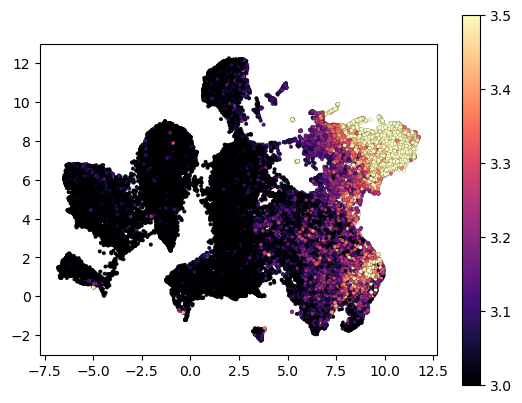

In [31]:
# plot clustering
fig, ax = plt.subplots()
sc = plt.scatter(clus_data['emb1'], clus_data['emb2'], c=clus_data['PDL1'], cmap='magma', s=7.5, ec='k', lw=0.1, vmin=3.0, vmax=3.5)
plt.colorbar(sc)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'cmap.png'), dpi=1000)
plt.show()
plt.close('all')

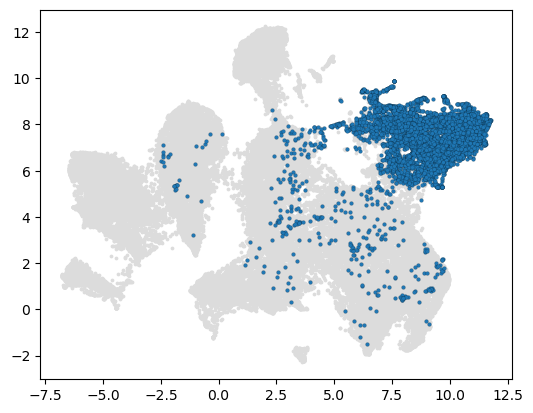

In [15]:
in_roi = clus_data[clus_data['CellID'].isin(cell_ids)]
out_roi = clus_data[~clus_data['CellID'].isin(cell_ids)]

fig, ax = plt.subplots()
plt.scatter(out_roi['emb1'], out_roi['emb2'], c='gainsboro', s=7.5, ec=[0.0, 0.0, 0.0], lw=0.0, alpha=1.0)
plt.scatter(in_roi['emb1'], in_roi['emb2'], c='tab:blue', s=7.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'gating.png'), dpi=1000)
plt.show()
plt.close('all')

55619 cells


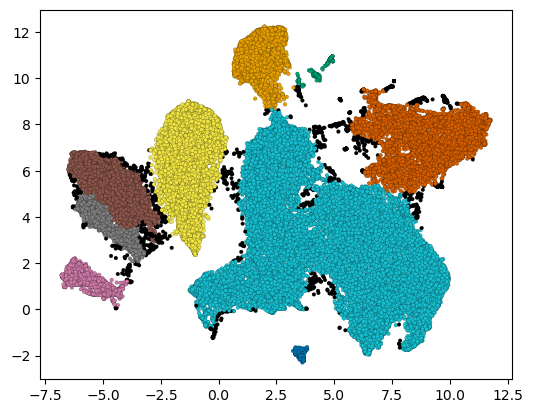

In [19]:
clustering = hdbscan.HDBSCAN(min_cluster_size=100).fit(clus_data[['emb1', 'emb2']])
clus_data['cluster'] = clustering.labels_

# generate categorical cmap for clusters
cmap = categorical_cmap(
    numUniqueSamples=len(clus_data['cluster'].unique()),
    numCatagories=10,
    cmap='tab10', continuous=False)

cmap = ListedColormap(
    np.insert(
        arr=cmap.colors, obj=0,
        values=[0, 0, 0], axis=0)
        )

# trim cmap to # unique samples
trim = (
    len(cmap.colors) - len(
        clus_data['cluster'].unique())
    )
cmap = ListedColormap(
    cmap.colors[:-trim]
    )

sample_dict = dict(
    zip(
        natsorted(
            clus_data['cluster'].unique()),
        list(range(len(clus_data['cluster']
             .unique()))))
        )

c = [sample_dict[i] for i
     in clus_data['cluster']]

print(f'{len(clus_data)} cells')

fig, ax = plt.subplots()
plt.scatter(clus_data['emb1'], clus_data['emb2'], c=c, cmap=cmap, s=7.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.savefig(os.path.join(save_dir, 'clustering.png'), dpi=1000)
plt.show()
plt.close('all')

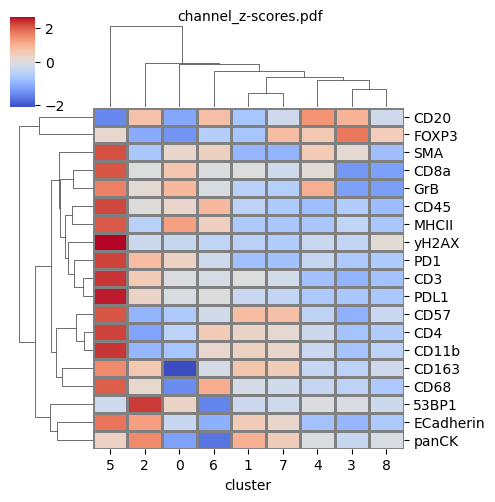

In [17]:
clustermap_input = clus_data[include + ['cluster']].groupby(['cluster']).mean()
clustermap_input = clustermap_input[clustermap_input.index != -1]

# compute per channel z-scores across gated populations 
clustermap_input = (
    (clustermap_input - clustermap_input.mean()) / clustermap_input.std()
)

# zero-center colorbar
norm = TwoSlopeNorm(
    vcenter=0, vmin=clustermap_input.min().min(),
    vmax=clustermap_input.max().max()
)

g = sns.clustermap(
    clustermap_input.T, cmap='coolwarm', standard_scale=None, square=False,
    xticklabels=1, yticklabels=1, linewidth=1.0, linecolor='grey', 
    cbar=True, norm=norm, figsize=(5, 5)
)

g.fig.suptitle('channel_z-scores.pdf', y=0.995, fontsize=10)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig(
    os.path.join(save_dir, 'channel_z-scores.pdf'), bbox_inches='tight'
)
plt.show()
plt.close('all')